In [1]:
#!/usr/bin/env python
# coding: utf-8

#########
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import cartopy.crs as ccrs
import copy
import pandas as pd
import seaborn as sns



In [2]:
### Preprocessing ###
## Load SST
ddir = '/home/disk/atmos/vcooper/work/p2c2/lgm/'
dfile = 'lgmDA_hol_SST_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).sst,
                   tempds.set_coords(['lat','lon','month']).sst_std])
holo_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_sst_climo['mask'] = xr.where(~np.isnan(holo_sst_climo.sst.isel(nmonth=0)), 1, 0)

dfile = 'lgmDA_lgm_SST_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).sst,
                   tempds.set_coords(['lat','lon','month']).sst_std])
lgm_sst_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
lgm_sst_climo['mask'] = xr.where(~np.isnan(lgm_sst_climo.sst.isel(nmonth=0)), 1, 0)

## Load ICEFRAC
dfile = 'lgmDA_hol_ICEFRAC_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).icefrac,
                   tempds.set_coords(['lat','lon','month']).icefrac_std])
holo_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
holo_ice_climo['mask'] = xr.where(~np.isnan(holo_ice_climo.icefrac.isel(nmonth=0)), 1, 0)

dfile = 'lgmDA_lgm_ICEFRAC_monthly_climo.nc'
ncf = ddir + dfile
tempds = xr.open_dataset(ncf)
tempds = xr.merge([tempds.set_coords(['lat','lon','month']).icefrac,
                   tempds.set_coords(['lat','lon','month']).icefrac_std])
lgm_ice_climo = tempds.assign_coords(month=('nmonth',np.arange(12)+1))
lgm_ice_climo['mask'] = xr.where(~np.isnan(lgm_ice_climo.icefrac.isel(nmonth=0)), 1, 0)
#####################

## regrid the lgm sst onto the sea ice grid
newgrid = lgm_ice_climo # desired grid
data_for_regridding = lgm_sst_climo

regridder = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',#ignore_degenerate=True,
                         periodic=True,
                         filename='bilinear_sst_to_ice_per.nc',
                         reuse_weights=True)
print(regridder)

## regrid the lgm sst onto the sea ice grid
newgrid = holo_ice_climo # desired grid
data_for_regridding = holo_sst_climo

regridder_holo = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',#ignore_degenerate=True,
                         periodic=True,
                         filename='bilinear_sst_to_ice_per_holo.nc',
                         reuse_weights=True)

# for msel in range(1): ## FIX ME
    
msel=0
mstr = str(msel+1).zfill(2)

path = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
merged_load = xr.open_dataset(path + 
                                 'lgmDA_lgm_SST_monthly_climo_merged_' + mstr +'.nc')
merged_load = merged_load.sst

ds = lgm_sst_climo.sst[msel]
ds_ice = lgm_ice_climo.icefrac[msel]

print(ds_ice.min())

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_sst_to_ice_per.nc 
Reuse pre-computed weights? True 
Input grid shape:           (384, 320) 
Output grid shape:          (96, 144) 
Periodic in longitude?      True
<xarray.DataArray 'icefrac' ()>
array(1.16276571e-31)
Coordinates:
    month    int64 1


In [3]:
print(ds_ice.min())

<xarray.DataArray 'icefrac' ()>
array(1.16276571e-31)
Coordinates:
    month    int64 1


In [4]:


ds_holo = holo_sst_climo.sst[msel]
ds_ice_holo = holo_ice_climo.icefrac[msel]
ds_ice_holo_wmask = holo_ice_climo

ds_temp_icegrid = regridder(ds)
ds_holo_icegrid = regridder_holo(ds_holo)
ds_temp_icegrid['mask'] = ~np.isnan(ds_temp_icegrid)
ds_holo_icegrid['mask'] = ~np.isnan(ds_holo_icegrid)

merged_icegrid = regridder_holo(merged_load)
merged_icegrid['mask'] = xr.where(~np.isnan(merged_icegrid),1,0)
merged_load['mask'] = xr.where(~np.isnan(merged_load),1,0)

## extrapolate the regridding to cover all cells with sea ice, since there 
## are some sea ice locations that show up as nan SST
newgrid = holo_ice_climo.icefrac[msel]
newgrid = newgrid.to_dataset()
newgrid['icefrac'] = newgrid.icefrac.where(newgrid.icefrac > 0.01)
newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac),1,0)
newgrid

data_for_regridding = merged_load.drop('mask').to_dataset(name='sst')
data_for_regridding['mask'] = xr.where(~np.isnan(data_for_regridding.sst),1,0)
data_for_regridding

regridder_extrap = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',
                         filename='bilinear_mergedSST_to_holoSIC_per_extrapID.nc',
                         reuse_weights=True)

merged_icegrid_extrap = regridder_extrap(data_for_regridding)

## this now has all of the places where we need sea ice
merged_icegrid = xr.where(
    np.isnan(merged_icegrid_extrap.sst),
    merged_icegrid,merged_icegrid_extrap.sst)
merged_icegrid['mask'] = xr.where(~np.isnan(merged_icegrid),1,0)

## subset data to fit SIC vs. SST lowess relation; only use NH for fit
#     sub_sic = ds_ice.where(ds_ice.lat > 10).values[
#         (ds_ice>0.01) & (ds_temp_icegrid > -1.78) & (ds_temp_icegrid < 1.5)]
#     sub_sst = ds_temp_icegrid.where(ds_temp_icegrid.lat > 10).values[
#         (ds_ice>0.01) & (ds_temp_icegrid > -1.78) & (ds_temp_icegrid < 1.5)]
# use holocene data for the fit since more relevant to infilling
sub_sic = ds_ice_holo.where(ds_holo_icegrid.lat > 10).values[
    (ds_ice_holo>0.01) & (ds_holo_icegrid > -1.8) & (ds_holo_icegrid < 3)]
sub_sst = ds_holo_icegrid.where(ds_holo_icegrid.lat > 10).values[
    (ds_ice_holo>0.01) & (ds_holo_icegrid > -1.8) & (ds_holo_icegrid < 3)]


## lowess regression in seaborn
df = pd.DataFrame(np.vstack([sub_sst,sub_sic]).T,columns=['sst','sic'])

f = sns.regplot(x='sst', y='sic',data=df,
                lowess=True, scatter_kws={"alpha": 0.1,'color':'k'},color='royalblue')
fit = f.lines[0].get_xydata()
plt.clf()

## adjust fit to manually add on ends to -2,100% and 1.0,0%
xfit = np.append(np.linspace(-2,fit[:,0][0],5),
                 np.append(fit[:,0],3))
yfit = np.append(np.linspace(1,fit[:,1][1],5),
                 np.append(fit[:,1],0))

## where masks are different (and there isnt ice already), need to check for new ice

## lgm mask: either there is an SST from regridded, or there is more than 1% ice
# NB: need to add the 1% ice check because native ice grid appears to have
# sea ice where regridding yields land
lgmmask = ~np.isnan(ds_temp_icegrid) | (ds_ice > 0.01)
# lgmmask.plot()
# plt.show()

## new mask is all of the new, regridded SSTs where there could be sea ice
newmask = ~np.isnan(merged_icegrid)
# newmask.plot()
# plt.show()

## diffmask is only places where sea ice should potentially be added
diffmask = xr.where((newmask > 0) & (lgmmask < 1),1,0)
# diffmask.plot()
# plt.show()

## get all of the SSTs for cells that were previously masked
sst_ofnewice = merged_icegrid.where(diffmask==1)

## NORTHERN HEMISPHERE
## find closest SIC based on lowess fit
yind = np.argmin(
    (sst_ofnewice.values[:,:,np.newaxis] - xfit)**2,axis=2)
newsic = yfit[yind.ravel()].reshape(yind.shape)

/home/disk/atmos/vcooper/miniconda3/envs/beauchard/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard/lib/python3.7/site-packages/xesmf/frontend.py:534: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,
/home/disk/atmos/vcooper/miniconda3/envs/beauchard/lib/python3.7/site-packages/xesmf/frontend.py:567: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs,


NameError: name 'newsice' is not defined

<Figure size 432x288 with 0 Axes>

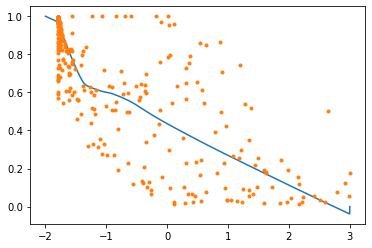

In [10]:
plt.plot(xfit,yfit)
plt.plot(sub_sst,sub_sic,ls='',marker='.')

array([1.        , 0.99287624, 0.98575247, 0.97862871, 0.97150495,
       0.97150524, 0.97150495, 0.97150373, 0.97149154, 0.97148797,
       0.97148646, 0.97148148, 0.97146972, 0.971467  , 0.97146162,
       0.97145791, 0.97145757, 0.97144301, 0.9714081 , 0.97140803,
       0.97140568, 0.97139273, 0.9713917 , 0.97137403, 0.97135984,
       0.97135661, 0.97135446, 0.97134471, 0.97133005, 0.97130866,
       0.97130265, 0.97130135, 0.97128639, 0.9712829 , 0.97127682,
       0.97127399, 0.97127305, 0.97127026, 0.97126967, 0.97124332,
       0.97124229, 0.97123336, 0.97122531, 0.97120097, 0.97119685,
       0.97117585, 0.97116388, 0.97116285, 0.9711467 , 0.97113892,
       0.97110398, 0.97108214, 0.97107732, 0.97107244, 0.97107164,
       0.97105712, 0.97103222, 0.9709965 , 0.97098524, 0.97097741,
       0.97092412, 0.97091913, 0.9708873 , 0.97085107, 0.97075356,
       0.97072862, 0.97062507, 0.97056685, 0.97050105, 0.97033954,
       0.97031796, 0.97028245, 0.97023189, 0.97021569, 0.97020

In [5]:
print(newsic.min())

-0.02766777907003973


In [ ]:
icecombo = xr.where(diffmask != 0, newsic, ds_ice)

## SOUTHERN HEMISPHERE
## use xesmf extrapolation
newgrid = holo_ice_climo.icefrac[msel]
newgrid = newgrid.to_dataset()
newgrid['icefrac'] = newgrid.icefrac.where(newgrid.icefrac > 0.01)
newgrid['mask'] = xr.where(~np.isnan(newgrid.icefrac),1,0)
newgrid

data_for_regridding = ds_ice.to_dataset(name='icefrac')
data_for_regridding['mask'] = xr.where(~np.isnan(ds_temp_icegrid) | (ds_ice>0.01),1,0)
data_for_regridding['icefrac'] = data_for_regridding.icefrac.where(data_for_regridding.mask > 0)
data_for_regridding

regridder_SICextrap = xe.Regridder(data_for_regridding, newgrid,
                         method='bilinear',
                         periodic=True,
                         extrap_method='inverse_dist',extrap_num_src_pnts=8*4,
#                          filename='bilinear_mergedSST_to_holoSIC_per_extrapID.nc',
                         reuse_weights=False)

ice_extrap = regridder_SICextrap(data_for_regridding)

diffmask2 = xr.where((newgrid.mask > 0) & 
                 (newgrid.mask != data_for_regridding.mask),1,0)

merged_icegrid2 = xr.where(diffmask2 != 0, ice_extrap.icefrac, ds_ice)

merged_icegrid2['mask'] = xr.where(~np.isnan(merged_icegrid2),1,0)

## put NH and SH together
icecombo2 = xr.where(icecombo.lat < 0, merged_icegrid2, icecombo)

## save files
savepath = '/home/disk/sipn/vcooper/nobackup/lgm/infilled/'
fname = 'lgmDA_lgm_ICEFRAC_monthly_climo_merged_' + mstr + '.nc'

icecombo2.to_netcdf(savepath + fname)
print('finished saving month ' + mstr)


## PLOTTING TO CHECK RESULTS
# proj = ccrs.NorthPolarStereo()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_temp_icegrid,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Original SST from LGM on ice grid')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Ice in LGM (no actual mask for SIC data)')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice.where(lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Original Ice in LGM with Implied Mask')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice.where(newmask | lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('New Ocean Mask, Original LGM Ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                (diffmask*1).where(newmask | lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap='cividis',alpha=1)
# plt.title('Possible new locations for sea ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 36, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                icecombo,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Infilled Ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, 40, 90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice_holo,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Holocene reference')
# plt.colorbar()
# plt.show()

# proj = ccrs.SouthPolarStereo()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_temp_icegrid,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Original SST from LGM on ice grid')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Ice in LGM (no actual mask for SIC data)')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice.where(lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Original Ice in LGM with Implied Mask')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice.where(newmask | lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('New Ocean Mask, Original LGM Ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                (diffmask*1).where(newmask | lgmmask),
#                transform=ccrs.PlateCarree(),
#                cmap='cividis',alpha=1)
# plt.title('Possible new locations for sea ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                icecombo,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Infilled Ice')
# plt.colorbar()
# plt.show()

# fig = plt.subplots(figsize=(8,6))
# ax = plt.subplot(projection=proj)
# ax.coastlines(color='0.5')
# ax.set_extent([-180, 180, -40, -90], ccrs.PlateCarree())
# plt.pcolormesh(ds_ice.lon,ds_ice.lat,
#                ds_ice_holo,
#                transform=ccrs.PlateCarree(),
#                cmap=cmap_nan,alpha=1)
# plt.title('Holocene reference')
# plt.colorbar()
# plt.show()